In [2]:
!pip install conllu

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from conllu import parse
from collections import defaultdict
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
import warnings
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Extracting data and making dictionaries
def extract_data_and_create_dictionaries(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = file.read()
    sentences = parse(data)
    words_to_idx = {}
    pos_tags_to_idx = {}
    extracted_data = []
    word_idx = 0
    pos_tag_idx = 0
    for sentence in sentences:
        words = []
        pos_tags = []
        for token in sentence:
            token_id = str(token['id'])  # convert token ID to string
            if '-' not in token_id:  # ignoring multi-word tokens
                word = token['form'].lower()
                pos_tag = token['upos']
                words.append(word)
                pos_tags.append(pos_tag)
                if word not in words_to_idx:
                    words_to_idx[word] = word_idx
                    word_idx += 1
                if pos_tag not in pos_tags_to_idx:
                    pos_tags_to_idx[pos_tag] = pos_tag_idx
                    pos_tag_idx += 1
        extracted_data.append([words, pos_tags])
    words_to_idx['<s>'] = len(words_to_idx)
    words_to_idx['</s>'] = len(words_to_idx)
    words_to_idx['<unk>'] = len(words_to_idx)
    return extracted_data, words_to_idx, pos_tags_to_idx


# Finding frequency of words
def find_word_frequency(train_data):
    all_words = [word for sentences , tags in train_data for word in sentences]
    word_freq = {}
    for w in all_words:
        word_freq[w] = word_freq.get(w,0)+1
    return word_freq



# Paths to train, dev, and test files
train_file_path = "en_atis-ud-train.conllu"
dev_file_path = "en_atis-ud-dev.conllu"
test_file_path = "en_atis-ud-test.conllu"


# Calling functions for making dictionary
train_data, word_to_idx, pos_tag_to_idx= extract_data_and_create_dictionaries(train_file_path)
dev_data, _, _= extract_data_and_create_dictionaries(dev_file_path)
test_data, _, _= extract_data_and_create_dictionaries(test_file_path)
word_freq=find_word_frequency(train_data)

pos_tag_to_idx = {pos: i for i, pos in enumerate(sorted(pos_tag_to_idx.keys()))}
pos_tag_to_idx['<UNSEEN_POS>'] = len(pos_tag_to_idx)

In [4]:
# Padding start here, end and unk(unknown) tags
def add_tags(words, p, s, word_freq):
    start_tags = ['<s>'] * p
    end_tags = ['</s>'] * s
    words_with_tags = [word if word_freq[word] > 3 else '<unk>' for word in words]
    return start_tags + words_with_tags + end_tags


# Creating embeddings
# Converting words to one-hot encodings using PyTorch
def words_to_one_hot(words, word_to_idx):
    vocab_size = len(word_to_idx)
    one_hot_encodings = []
    for word in words:
        if word in word_to_idx:
            word_idx = word_to_idx[word]
        else:
            word_idx = word_to_idx['<unk>']
        one_hot_encoding = torch.nn.functional.one_hot(torch.tensor(word_idx), num_classes=vocab_size)
        one_hot_encodings.append(one_hot_encoding.numpy())
    return one_hot_encodings


p = 2  # Number of preceding tokens
s = 2  # Number of antecedent tokens

# Words in train_data to one-hot encodings
train_data_one_hot = []

for words, pos_tags in train_data:
    words_with_tags = add_tags(words, p, s, word_freq)
    words_one_hot = words_to_one_hot(words_with_tags, word_to_idx)
    train_data_one_hot.append((words_one_hot, pos_tags))


# Creating list of one hot of all words present
all_words_with_one_hot = []
for i,word in enumerate(word_to_idx):
    vocab_size = len(word_to_idx)
    one_hot_encoding = torch.nn.functional.one_hot(torch.tensor(i), num_classes=vocab_size)
    all_words_with_one_hot.append([one_hot_encoding,word])

In [5]:
class FFNN_POS_Tagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN_POS_Tagger, self).__init__()
        # input, hidden, and output sizes of the network
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Defining the first linear layer
        self.input_to_hidden = nn.Linear(input_size, hidden_size)
        # Defining the ReLU activation function
        self.activation = nn.ReLU()
        # Define the second linear layer
        self.hidden_to_output = nn.Linear(hidden_size, output_size)

    def forward(self, input_data):
        # Performing the forward pass through the network
        # Applying the first linear transformation
        hidden_output = self.input_to_hidden(input_data)
        # Applying the ReLU activation function
        hidden_output = self.activation(hidden_output)
        # Applying the second linear transformation
        final_output = self.hidden_to_output(hidden_output)
        # Returning the final output without any activation function
        return final_output


# Context window size
input_size = (p + s + 1) * len(word_to_idx)
hidden_size = 256
output_size = len(pos_tag_to_idx)


pos_tag_model = FFNN_POS_Tagger(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pos_tag_model.parameters(), lr=0.001)

In [6]:
# Getting embedding for all the contexts(sentence)
def get_context_embeds(sentence, pos_tags, one_hot_encode, p, s):
    context_embeds = []
    token = '<unk>'
    label_embeds = []

    for i in range(p, len(sentence) - s):
        word_context_embed = []

        for j in range(i - p, i + s + 1):
            if 0 <= j < len(sentence):
                current_word = sentence[j]
            else:
                current_word = token

            word_frequency = word_freq.get(current_word, 0)
            if word_frequency < 3:
                current_word = token

            index = [word for _, word in one_hot_encode].index(current_word)
            word_one_hot_vec = one_hot_encode[index][0]
            word_context_embed += word_one_hot_vec.tolist()

        context_embeds.append(word_context_embed)

        # Checking if the part-of-speech tag is present in the dictionary
        if pos_tags[i-p] not in pos_tag_to_idx:
            # Checking the case when the part-of-speech tag is unseen
            label_embeds.append(pos_tag_to_idx['<UNSEEN_POS>'])
        else:
            label_embeds.append(pos_tag_to_idx[pos_tags[i-p]])

    context_embeds_tensor = torch.tensor(context_embeds, dtype=torch.float32)
    label_embeds_tensor = torch.tensor(label_embeds , dtype=torch.long)
    return context_embeds_tensor,label_embeds_tensor



train_context_embeds = []
embeds_labels = []
for sentences , pos_tags in train_data:
    a , b = get_context_embeds(sentences, pos_tags , all_words_with_one_hot, p, s)
    train_context_embeds.append(a)
    embeds_labels.append(b)


In [7]:
# Making Dataset
class PosTaggingDataset(Dataset):
    def __init__(self, context_embeddings, label_embeddings):
        self.context_embeddings = context_embeddings
        self.label_embeddings = label_embeddings

    def __len__(self):
        return len(self.context_embeddings)

    def __getitem__(self, idx):
        context_embeds = self.context_embeddings[idx]
        label_embeds = self.label_embeddings[idx]
        return context_embeds, label_embeds


# Collate function is basically used for padding
def collate_fn(batch):
    # Filter out batches where label sequences are empty
    batch = [(context, label) for context, label in batch if len(label) > 0]

    if len(batch) == 0:
        return torch.tensor([]), torch.tensor([])

    # Sorting the batch by the length of the input sequences
    batch.sort(key=lambda x: len(x[0]), reverse=True)

    # Separating the input sequences and label sequences
    contexts = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Findind the length of the longest sequence in the batch
    max_len = max(len(seq) for seq in contexts)

    # Padding the sequences within each batch to the length of the longest sequence
    padded_contexts = pad_sequence(contexts, batch_first=True, padding_value=0)
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=0)

    return padded_contexts, padded_labels


pos_dataset = PosTaggingDataset(train_context_embeds, embeds_labels)

pos_dataloader = DataLoader(PosTaggingDataset(train_context_embeds, embeds_labels),
                             batch_size=32, shuffle=True,collate_fn=collate_fn)


In [10]:
#Calculating average loss for each Epoch (1 Epoch means one iteration of whole data)

# Number of epochs
epochs = 5

# Training loop
for epoch in range(epochs):
    total_loss = 0.0

    # Setting the model to training mode
    pos_tag_model.train()

    # Iterating over the batches
    for batch in pos_dataloader:
        context_embeds, label_embeds = batch

        # Clearing the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = pos_tag_model(context_embeds)

        # Computing the loss
        loss = criterion(outputs.view(-1, output_size), label_embeds.view(-1))

        # Backward pass
        loss.backward()

        # Updating the parameters
        optimizer.step()

        # Accumulating the loss
        total_loss += loss.item()

    # Calculating the average loss for the epoch
    average_loss = total_loss / len(pos_dataloader)

    # Print the average loss for the epoch
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {average_loss:.4f}')


# Saving the model
torch.save(pos_tag_model.state_dict(), "model.pt")

Epoch [1/5], Average Loss: 0.0109
Epoch [2/5], Average Loss: 0.0094
Epoch [3/5], Average Loss: 0.0080
Epoch [4/5], Average Loss: 0.0073
Epoch [5/5], Average Loss: 0.0071


In [11]:
# torch.load("model.pt")
# pos_tag_model.eval()


#Testing the model using Dev dataset

# Loading dev data and preprocess
dev_data, _, _ = extract_data_and_create_dictionaries(dev_file_path)

# Preprocessing dev data
dev_context_embeds = []
dev_embeds_labels = []
for sentences, pos_tags in dev_data:
    a, b = get_context_embeds(sentences, pos_tags, all_words_with_one_hot, p, s)
    dev_context_embeds.append(a)
    dev_embeds_labels.append(b)

# Creating DataLoader for dev data
dev_dataset = PosTaggingDataset(dev_context_embeds, dev_embeds_labels)
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Evaluation
pos_tag_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in dev_dataloader:
        context_embeds, label_embeds = batch
        outputs = pos_tag_model(context_embeds)
        _, predicted = torch.max(outputs, 2)
        total += label_embeds.numel()
        correct += (predicted == label_embeds).sum().item()

accuracy = correct / total
print(f"Accuracy on dev data: {accuracy}")



#Testing the model using Test dataset
# Loading hte test data and preprocessing it
test_data, _, _ = extract_data_and_create_dictionaries(test_file_path)

# Preprocessing test data
test_context_embeds = []
test_embeds_labels = []
for sentences, pos_tags in test_data:
    a, b = get_context_embeds(sentences, pos_tags, all_words_with_one_hot, p, s)
    test_context_embeds.append(a)
    test_embeds_labels.append(b)

# Creating DataLoader for test data
test_dataset = PosTaggingDataset(test_context_embeds, test_embeds_labels)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Evaluation on test data
correct = 0
total = 0

with torch.no_grad():
    for batch in test_dataloader:
        context_embeds, label_embeds = batch
        outputs = pos_tag_model(context_embeds)
        _, predicted = torch.max(outputs, 2)
        total += label_embeds.numel()
        correct += (predicted == label_embeds).sum().item()

accuracy = correct / total
print(f"Accuracy on test data: {accuracy}")


Accuracy on dev data: 0.9877853881278539
Accuracy on test data: 0.9877917414721723


In [12]:
# Getting context embeddings of input sentence

def get_input_context_embeddings(sentence, all_words_with_one_hot, p, s, word_freq):
    # Tokenization of the sentence into words
    words = sentence.lower().split()

    # CPadding the input sentence
    start_tags = ['<s>'] * p
    end_tags = ['</s>'] * s
    words = start_tags + words + end_tags

    # Getting context embeddings
    context_embeds = []
    token = '<unk>'

    for i in range(p, len(words) - s):
        word_context_embed = []
        for j in range(i - p, i + s + 1):
            if 0 <= j < len(words):
                current_word = words[j]
            else:
                current_word = token

            freq=word_freq.get(current_word,0)
            if freq<3:
                current_word=token

            index = [word for _, word in all_words_with_one_hot].index(current_word)
            word_one_hot_vec = all_words_with_one_hot[index][0]
            word_context_embed += word_one_hot_vec.tolist()

        context_embeds.append(word_context_embed)

    return torch.tensor(context_embeds, dtype=torch.float32)

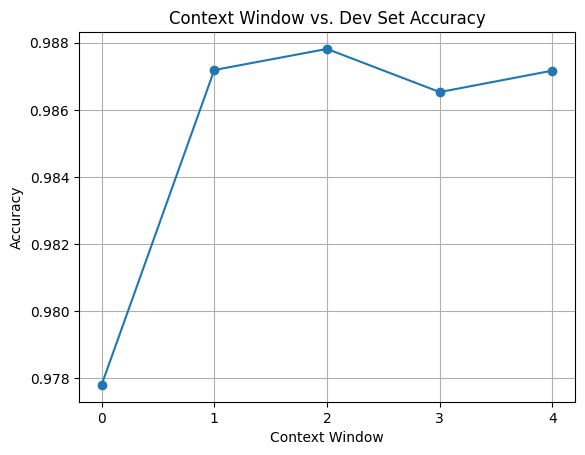

In [13]:
# Function to train and evaluate the model for context_window size
def train_and_evaluate(context_window):
    # Modifying  existing code to set p = s = context_window
    p = s = context_window

    # Getting context embeddings for training data
    train_context_embeds = []
    embeds_labels = []
    for sentences, pos_tags in train_data:
        a, b = get_context_embeds(sentences, pos_tags, all_words_with_one_hot, p, s)
        train_context_embeds.append(a)
        embeds_labels.append(b)

    # Creating DataLoader for training data
    pos_dataset = PosTaggingDataset(train_context_embeds, embeds_labels)
    pos_dataloader = DataLoader(pos_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

    # Initialize the model
    input_size = train_context_embeds[0].shape[-1]
    pos_tag_model = FFNN_POS_Tagger(input_size, hidden_size, output_size)

    # Initialize criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(pos_tag_model.parameters(), lr=0.001)

    # Number of epochs
    epochs = 5

    # Training loop
    for epoch in range(epochs):
        total_loss = 0.0
        pos_tag_model.train()  # Setting the model to training mode
        for batch in pos_dataloader:
            context_embeds, label_embeds = batch
            optimizer.zero_grad()  # Clearing the gradients
            outputs = pos_tag_model(context_embeds)  # Forward pass
            loss = criterion(outputs.view(-1, output_size), label_embeds.view(-1))  # Computing the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the parameters
            total_loss += loss.item()  # Accumulating the loss

    # Evaluating the model on the development set
    dev_context_embeds = []
    dev_embeds_labels = []
    for sentences, pos_tags in dev_data:
        a, b = get_context_embeds(sentences, pos_tags, all_words_with_one_hot, p, s)
        dev_context_embeds.append(a)
        dev_embeds_labels.append(b)

    dev_dataset = PosTaggingDataset(dev_context_embeds, dev_embeds_labels)
    dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    pos_tag_model.eval()  # Setting the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dev_dataloader:
            context_embeds, label_embeds = batch
            outputs = pos_tag_model(context_embeds)
            _, predicted = torch.max(outputs, 2)
            total += label_embeds.numel()
            correct += (predicted == label_embeds).sum().item()

    accuracy = correct / total
    return accuracy

# Defining a list of context_window values to test
context_window_values = list(range(5))

# List to store accuracies for different context_window values
accuracies = []

# Iterate over context_window values and train the model
for context_window in context_window_values:
    accuracy = train_and_evaluate(context_window)
    accuracies.append(accuracy)

# Plot the graph
plt.plot(context_window_values, accuracies, marker='o')
plt.title('Context Window vs. Dev Set Accuracy')
plt.xlabel('Context Window')
plt.ylabel('Accuracy')
plt.xticks(context_window_values)
plt.grid(True)
plt.show()


Evaluation results for Dev Set:
Accuracy: 0.9850456621004566
Recall: 0.9371746591989396
F1 Score: 0.9462349741799996


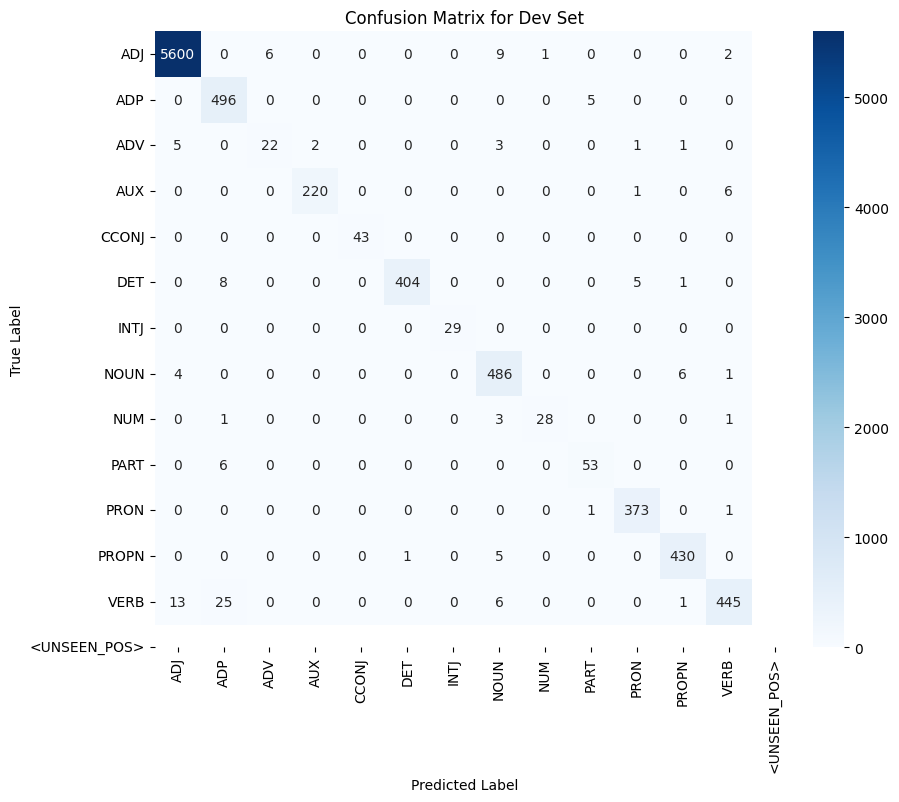


Evaluation results for Test Set:
Accuracy: 0.9868342309994016
Recall: 0.9292912376000925
F1 Score: 0.9432626786164058


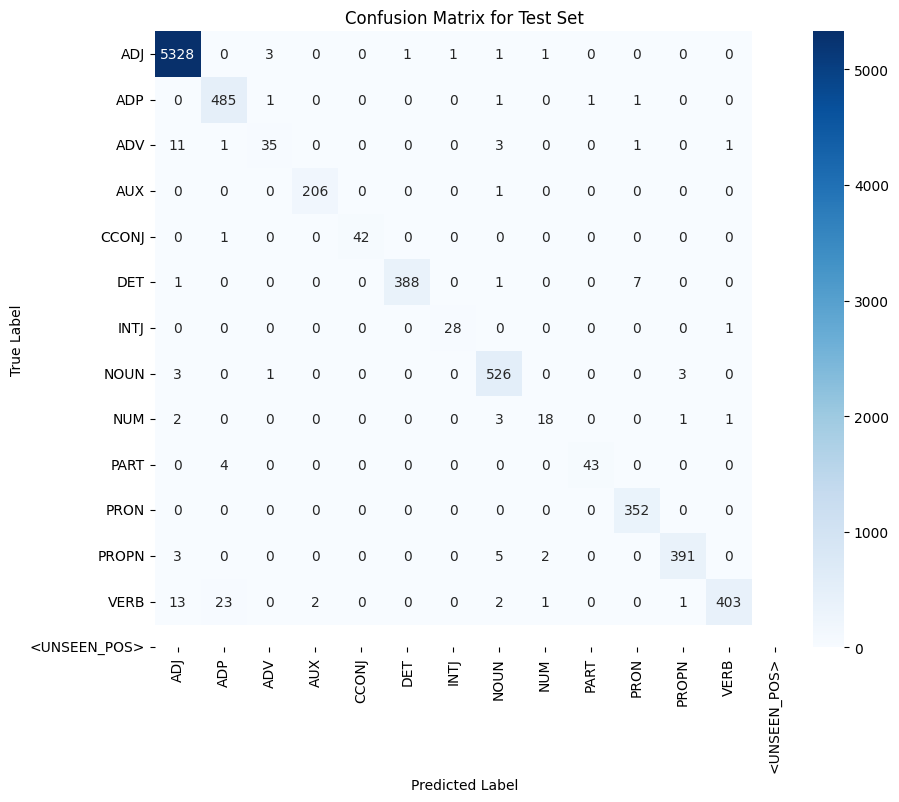

In [ ]:

# Function for evaluating model performance and generate confusion matrix
def evaluate_model(model, dataloader, dataset_name):
    # Setting model to evaluation mode
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            context_embeds, label_embeds = batch
            outputs = model(context_embeds)
            _, predicted = torch.max(outputs, 2)

            all_labels.extend(label_embeds.view(-1).numpy())
            all_predictions.extend(predicted.view(-1).numpy())

    # Calculating accuracy
    accuracy = accuracy_score(all_labels, all_predictions)

    # Calculating recall
    recall = recall_score(all_labels, all_predictions, average='macro')

    # Calculating F1 score
    f1 = f1_score(all_labels, all_predictions, average='macro')

    # Print evaluation metrics
    print(f"Evaluation results for {dataset_name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=pos_tag_to_idx.keys(), yticklabels=pos_tag_to_idx.keys())
    plt.title(f"Confusion Matrix for {dataset_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    print()

# Evaluating model on dev set
evaluate_model(pos_tag_model, dev_dataloader, "Dev Set")

# Evaluating model on test set
evaluate_model(pos_tag_model, test_dataloader, "Test Set")


In [1]:
def predict_pos_tags(sentence, pos_tag_model, all_words_with_one_hot, p, s, pos_tag_to_idx, word_freq):
    # Predict POS tags
    pos_tag_model.eval()

    # Get context embeddings for the sentence
    context_embeds = get_input_context_embeddings(sentence, all_words_with_one_hot, p, s, word_freq)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        context_embeds = torch.tensor(context_embeds, dtype=torch.float32).unsqueeze(0)

    with torch.no_grad():
        outputs = pos_tag_model(context_embeds)

    _, predicted = torch.max(outputs, 2)
    predicted = predicted.squeeze().tolist()

    # Map predicted indices to POS tags
    predicted_tags = [list(pos_tag_to_idx.keys())[list(pos_tag_to_idx.values()).index(idx)] for idx in predicted]

    return predicted_tags


# Example
sentence = "An apple a day keeps the doctor"
predicted_tags = predict_pos_tags(sentence, pos_tag_model, all_words_with_one_hot, p, s, pos_tag_to_idx, word_freq)
print(sentence.split())
print(predicted_tags)

NameError: name 'pos_tag_model' is not defined